In [1]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from IoU import IoU_value
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from interpret import show
from interpret.blackbox import LimeTabular
import pandas as pd
import numpy as np
import xgboost

# 导入数据（一个Kaggle上的小数据集)

数据来源：https://www.kaggle.com/zhijinzhai/loandata

In [2]:
df = pd.read_csv("E:/数据集/金融数据集/金融数据集/Loan data/Loan data/Loan payments data.csv")
df

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female
...,...,...,...,...,...,...,...,...,...,...,...
495,xqd20160496,COLLECTION_PAIDOFF,1000,30,9/12/2016,10/11/2016,10/14/2016 19:08,3.0,28,High School or Below,male
496,xqd20160497,COLLECTION_PAIDOFF,1000,15,9/12/2016,9/26/2016,10/10/2016 20:02,14.0,26,High School or Below,male
497,xqd20160498,COLLECTION_PAIDOFF,800,15,9/12/2016,9/26/2016,9/29/2016 11:49,3.0,30,college,male
498,xqd20160499,COLLECTION_PAIDOFF,1000,30,9/12/2016,11/10/2016,11/11/2016 22:40,1.0,38,college,female


# 数据预处理

In [3]:
def education(x):
    #print(x)
    if x =="High School or Below":
        x = 0
    elif x =="college":
        x = 1
    else:
        x =2
    #print(x)
    return x
def preprocess(df):
    df["loan_status"] = df["loan_status"].apply(lambda x: int(x!="PAIDOFF"))
    del df["Loan_ID"],df["effective_date"],df["due_date"],df["paid_off_time"],df["loan_status"]
    df["education"] = df["education"].apply(lambda x: education(x))
    df["past_due_days"] = df["past_due_days"].fillna(0)
    df["Gender"] = df["Gender"].apply(lambda x: int(x =="male"))
    return df
df = preprocess(df)

## past_due_days为目标字段，设定past_due_days>7为正样本

In [4]:
def split_target_data(df):
    header = list(df.columns)
    target = (df["past_due_days"]>7).astype(int)
    del header[header.index("past_due_days")]
    data = df[header]
    return data,target

In [5]:
data,target = split_target_data(df)
data

,Principal,terms,age,education,Gender
0,1000,30,45,0,1
1,1000,30,50,2,0
2,1000,30,33,2,0
3,1000,15,27,1,1
4,1000,30,28,1,0
...,...,...,...,...,...
495,1000,30,28,0,1
496,1000,15,26,0,1
497,800,15,30,1,1
498,1000,30,38,1,0


## 划分训练集测试集

In [6]:
X_train,X_test,y_train,y_test = train_test_split(data,target, test_size = 0.3,random_state= 42)

## xgboost训练

In [7]:
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train,y_train)
xgb_clf.score(X_test,y_test)

[15:58:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.6266666666666667

## XGBoost 特征重要性：

<BarContainer object of 5 artists>

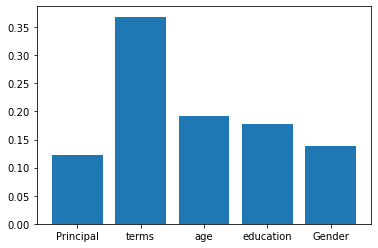

In [8]:
plt.bar(X_train.columns,xgb_clf.feature_importances_)

## LIME解释性

In [17]:
lime = LimeTabular(predict_fn=xgb_clf.predict_proba, data=X_train)  
lime_local = lime.explain_local(X_test.iloc[:5], y_test.iloc[:5])  #解释第0-5样本

show(lime_local)

# LIME与XGBoost特征重要性对比

# 设定的IoU指标，越大则表示两者相关性越高

Step1: list1,list2对应的前k个feature_name取交集$name_{intersection}$,取并集$name_{union}$ 

Step2: $IoU = \frac{\sum_{i \in name_{intersection}} \ max(vallist1[i],vallist2[i])}{\sum_{i \in name_{union}}  \ max(vallist1[i],vallist2[i])}$

## 获取feature_name 与对应权重

In [12]:
def get_name_val(lime_obj):
    name_list = [lime_obj._internal_obj['specific'][i]['names'] for i in range(len(lime_obj._internal_obj['specific']))]
    val_list = lime_obj._internal_obj['mli'][0]["value"]['scores']
    return name_list,val_list

name_list,val_list = get_name_val(lime_local)
val_list

[[-0.1426048352358213, 0.039990868480155185, -0.02371128243309834, 0.0, 0.0],
 [-0.12703678664108595, -0.11615037073297915, -0.08055815188730965, 0.0, 0.0],
 [0.1243081035147458, -0.0900893644982463, -0.03136913401933854, 0.0, 0.0],
 [0.13568793258750667, -0.10571047758553842, 0.059716049095911744, 0.0, 0.0],
 [-0.1251752071853905, -0.10617336525152035, -0.08778865126283497, 0.0, 0.0]]

In [15]:
for i in range(len(val_list)):
    lime_name = name_list[i]
    lime_val = val_list[i]
    xgb_name = list(X_train.columns)
    xgb_val = xgb_clf.feature_importances_
    print("第%s个样本的IoU值为：%.10f" %(i,IoU_value(lime_val,xgb_val,lime_name,xgb_name)))

第0个样本的IoU值为：0.1340679471
第1个样本的IoU值为：0.1016369918
第2个样本的IoU值为：0.5703787279
第3个样本的IoU值为：0.4522420575
第4个样本的IoU值为：0.1220179135


结果发现和Xgboost的全局特征重要性比较吻合的两个（样本2和样本3) 样本2猜错了

# 在生成的数据集中验证LIME

In [4]:
df = pd.read_csv("train/train_data_0.csv")  #10000x100数据，不包含Target
df

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99
0,84.071517,15,95,37,109.222187,41.054423,14,12.635977,14.010126,70,...,26,56,32,30,30,65,36.400093,55,44,11.299354
1,64.376450,12,39,40,108.267721,58.627029,46,80.431019,3.598875,70,...,28,38,69,28,10,44,32.313545,30,45,10.109159
2,61.747596,36,58,7,51.315514,10.865075,53,43.284407,52.822478,70,...,20,45,62,43,29,48,35.294801,27,70,11.926330
3,108.096804,32,73,59,40.416383,12.580249,70,19.908695,59.408556,70,...,26,7,57,68,3,42,37.391035,47,71,10.819648
4,93.659688,14,45,30,85.312636,47.390543,81,30.780931,44.901262,71,...,30,10,46,42,3,42,32.743209,42,47,11.301096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,46.443361,29,59,22,41.987071,57.629751,39,78.792761,4.834577,71,...,26,63,38,66,16,62,36.587602,31,50,7.942675
9996,101.995631,23,57,16,100.037233,41.170912,25,32.059358,31.253103,71,...,29,57,44,52,7,62,37.806850,31,70,11.128170
9997,79.100888,42,36,44,100.913728,59.806790,17,69.167360,47.454068,70,...,22,60,46,4,32,62,32.413842,52,59,10.260244
9998,97.844526,31,41,46,52.108113,51.004928,65,39.811859,36.990671,70,...,25,20,42,4,19,47,36.201993,27,54,8.643205


# exp1 线性生成Label,使用简单的全连接网络训练，再使用LIME解释

### 线性生成Label

$ y = 5 \times x_0 + 1 \times x_1 + 2 \times x_3$ 

In [5]:
def normalize(x):
    x_max = x.max()
    x_min = x.min()
    if x.max() == x.min():
        return x
    else:
        result = (x-x_min)/(x_max-x_min)
        return result

In [6]:
df["label"] = df.feature0 *1 + df.feature1 * 1 + df.feature3*1
df["label"] = (normalize(df["label"])>0.5).astype(int)
df

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,label
0,84.071517,15,95,37,109.222187,41.054423,14,12.635977,14.010126,70,...,56,32,30,30,65,36.400093,55,44,11.299354,0
1,64.376450,12,39,40,108.267721,58.627029,46,80.431019,3.598875,70,...,38,69,28,10,44,32.313545,30,45,10.109159,0
2,61.747596,36,58,7,51.315514,10.865075,53,43.284407,52.822478,70,...,45,62,43,29,48,35.294801,27,70,11.926330,0
3,108.096804,32,73,59,40.416383,12.580249,70,19.908695,59.408556,70,...,7,57,68,3,42,37.391035,47,71,10.819648,1
4,93.659688,14,45,30,85.312636,47.390543,81,30.780931,44.901262,71,...,10,46,42,3,42,32.743209,42,47,11.301096,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,46.443361,29,59,22,41.987071,57.629751,39,78.792761,4.834577,71,...,63,38,66,16,62,36.587602,31,50,7.942675,0
9996,101.995631,23,57,16,100.037233,41.170912,25,32.059358,31.253103,71,...,57,44,52,7,62,37.806850,31,70,11.128170,1
9997,79.100888,42,36,44,100.913728,59.806790,17,69.167360,47.454068,70,...,60,46,4,32,62,32.413842,52,59,10.260244,1
9998,97.844526,31,41,46,52.108113,51.004928,65,39.811859,36.990671,70,...,20,42,4,19,47,36.201993,27,54,8.643205,1


### 使用简单神经网络拟合

In [7]:
data = df.iloc[:,:-1]
label = df.iloc[:,-1]
X_train,X_test, y_train,y_test = train_test_split(data,label,test_size = 0.3)
X_train,X_valid, y_train,y_valid = train_test_split(X_train,y_train,test_size = 0.3)

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [data.shape[1],]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(200,activation="elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100,activation = "elu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid')
])
model.compile(loss = keras.losses.mean_squared_error,optimizer = "sgd",metrics= ["binary_accuracy"])
history = model.fit(X_train, y_train,epochs = 20, validation_data=(X_valid,y_valid))

Epoch 1/20
154/154 [==============================] - 1s 2ms/step - loss: 0.2409 - binary_accuracy: 0.5816 - val_loss: 0.3739 - val_binary_accuracy: 0.4981
Epoch 2/20
154/154 [==============================] - 0s 1ms/step - loss: 0.1784 - binary_accuracy: 0.7781 - val_loss: 0.2210 - val_binary_accuracy: 0.6048
Epoch 3/20
154/154 [==============================] - 0s 1ms/step - loss: 0.1358 - binary_accuracy: 0.8483 - val_loss: 0.1278 - val_binary_accuracy: 0.8481
Epoch 4/20
154/154 [==============================] - 0s 1ms/step - loss: 0.1096 - binary_accuracy: 0.8768 - val_loss: 0.0903 - val_binary_accuracy: 0.9048
Epoch 5/20
154/154 [==============================] - 0s 1ms/step - loss: 0.0854 - binary_accuracy: 0.9114 - val_loss: 0.0737 - val_binary_accuracy: 0.9252
Epoch 6/20
154/154 [==============================] - 0s 1ms/step - loss: 0.0737 - binary_accuracy: 0.9175 - val_loss: 0.0644 - val_binary_accuracy: 0.9376
Epoch 7/20
154/154 [==============================] - 0s 1ms/ste

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

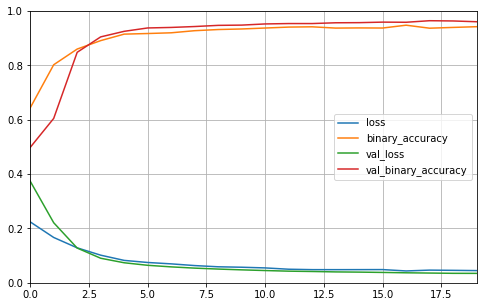

In [11]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

### 使用LIME预测的准备工作 

先自己写一个和xgboost.predict_proba类似的函数

In [12]:
def predict(series):
    if series.shape[0]*series.shape[1] == data.shape[1]:
        predict_0 = model.predict(np.array(series).reshape(1,-1))
        predict_1 = 1-model.predict(np.array(series).reshape(1,-1))
        result = []
        for i in range(predict_0.shape[0]):
            result.append([predict_0[i][0],predict_1[i][0]])
        return np.array(result)
    else:
        predict_0 = model.predict(np.array(series).reshape(int(series.shape[0]*series.shape[1]/data.shape[1]),-1))
        predict_1 = 1 - predict_0
        result = []
        for i in range(predict_0.shape[0]):
            result.append([predict_0[i][0],predict_1[i][0]])
        return np.array(result)

In [ ]:
lime = LimeTabular(predict_fn=predict, data=X_train)
lime_local = lime.explain_local(X_test.iloc[:5], y_test.iloc[:5])

show(lime_local)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### 看看和设定的线性函数有什么区别

In [ ]:
name_list,val_list = get_name_val(lime_local)
for i in range(len(val_list)):
    lime_name = name_list[i]
    lime_val = val_list[i]
    xgb_name = ["feature0","feature1","feature3"]
    xgb_val = [5,1,2]
    print("第%s个样本的IoU值为：%.10f" %(i,IoU_value(lime_val,xgb_val,lime_name,xgb_name)))